In [1]:
from __future__ import division, print_function

import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import models, fitting

from astroquery.irsa_dust import IrsaDust

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [3]:
def save_pub_figure(basename, figdir='figures', fig=None):
    import os
    if fig is None:
        fig = plt.gcf()
    plt.savefig(os.path.join(figdir, basename+'.pdf'))
    plt.savefig(os.path.join(figdir, basename+'.png'))

In [4]:
@models.custom_model  
def Logistic1D(x, x0=0, w=1):
    t = (x-x0)/w
    return 1/(1+np.exp(-t))

@models.custom_model    
def DipModel(x, xs=27.2, s=.8, xe=29, a=1.05, A=-.9, B=1.9):
    sig_component = (1+np.exp(-(x-xs)/s))**-1.
    exp_component = np.exp(a*(x-xe))
    return A*sig_component + B*exp_component

# Pisc A

In [109]:
d = np.loadtxt('PiscA_dolphot/piscA')
wcs = WCS(fits.getheader('PiscA_dolphot/PiscA_F606W_build_drc.chip1.fits'))

#object is roughly here
x0 = 3650
y0 = 5400

#control area
xc = 3500
yc = 3000

sc0 = SkyCoord.from_pixel(x0, y0, wcs)

In [110]:
ebvmap = IrsaDust.get_images(sc0,2*u.degree, 'ebv')[0][0].data
ebv = ebvmap[ebvmap.shape[0]//2, ebvmap.shape[0]//2]
A606W = ebv*2.471 # from S & F 11
A814W = ebv*1.526 # from S & F 11
A606W, A814W

(0.24128722241586581, 0.14901023933897661)

In [111]:
A606W - A814W

0.092276983076889196

In [112]:
# only use good stars
ds = d[d[:, 10]<2]

m606 = ds[:,15] - A606W
m606e = ds[:,17]
m814 = ds[:,28] - A814W
m814e = ds[:,30]

dpx_dwarf = np.hypot(x0-ds[:,2],y0-ds[:,3])
dpx_control = np.hypot(xc-ds[:,2],yc-ds[:,3])

In [113]:
sn = ds[:, 5]
sn606 = ds[:, 19]
sn814 = ds[:, 32]

In [114]:
 ce = np.hypot(m606e, m814e)
 me = m814e
 c = m606-m814
 m = m814

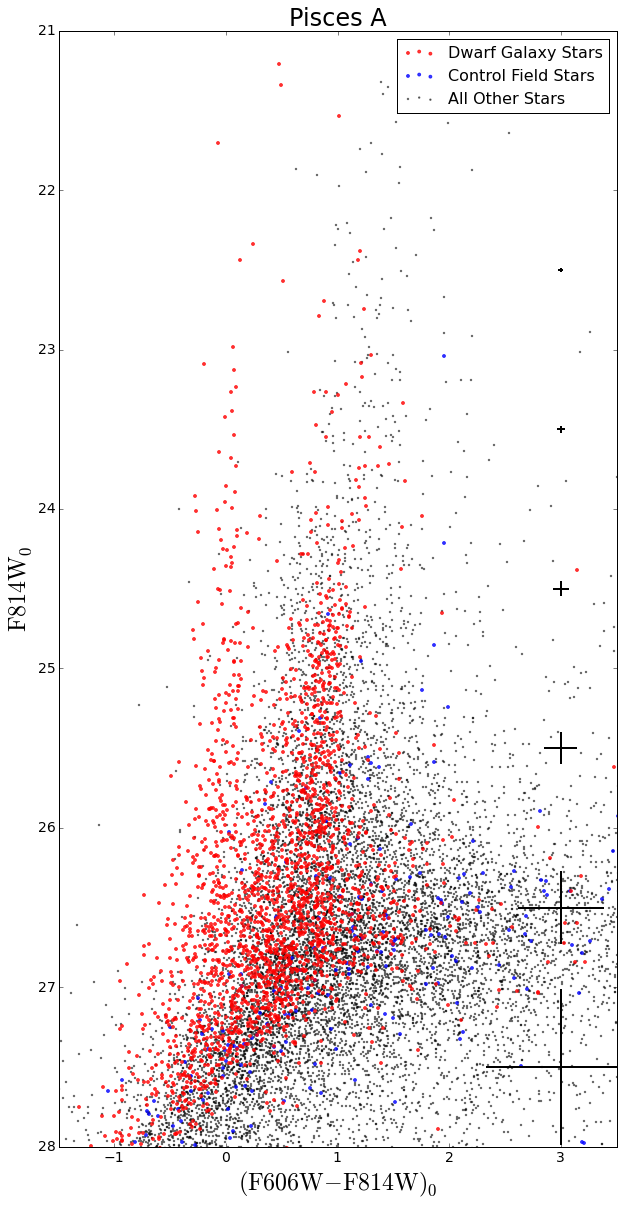

In [99]:
plt.figure(figsize=(10, 20))
plt.clf()

px_ap = 500
msk_dwarf = dpx_dwarf < px_ap
msk_control = dpx_control < px_ap
other = (~msk_dwarf)&(~msk_control)

plt.scatter(c[other], m[other], s=2, alpha=.5, color='k', label='All Other Stars')
plt.scatter(c[msk_control], m[msk_control], s=8, alpha=.75, color='b', label='Control Field Stars')
plt.scatter(c[msk_dwarf], m[msk_dwarf], s=8, alpha=.75, color='r', label='Dwarf Galaxy Stars')
plt.xlim(-1.5, 3.5)
plt.ylim(28, 21)

inbox = (min(plt.xlim())<c)&(c<max(plt.xlim()))&(min(plt.ylim())<m)&(m<max(plt.ylim()))
errmagbins = plt.yticks()[0]

binnum = np.digitize(m, errmagbins)
binmags = np.convolve(errmagbins, [0.5,0.5],mode='valid')
ces = [np.median(ce[(bi==binnum)&(ce<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]
mes = [np.median(me[(bi==binnum)&(me<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]

plt.errorbar([3]*len(binmags), binmags, mes, ces, fmt=None, capsize=0,ecolor='k',elinewidth=2)

plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)
plt.xticks(fontsize=14)
plt.ylabel(r'${\rm F814W}_0$',fontsize=24)
plt.yticks(fontsize=14)
plt.title('Pisces A',fontsize=24)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=16)
#save_pub_figure('PiscA_cmd')

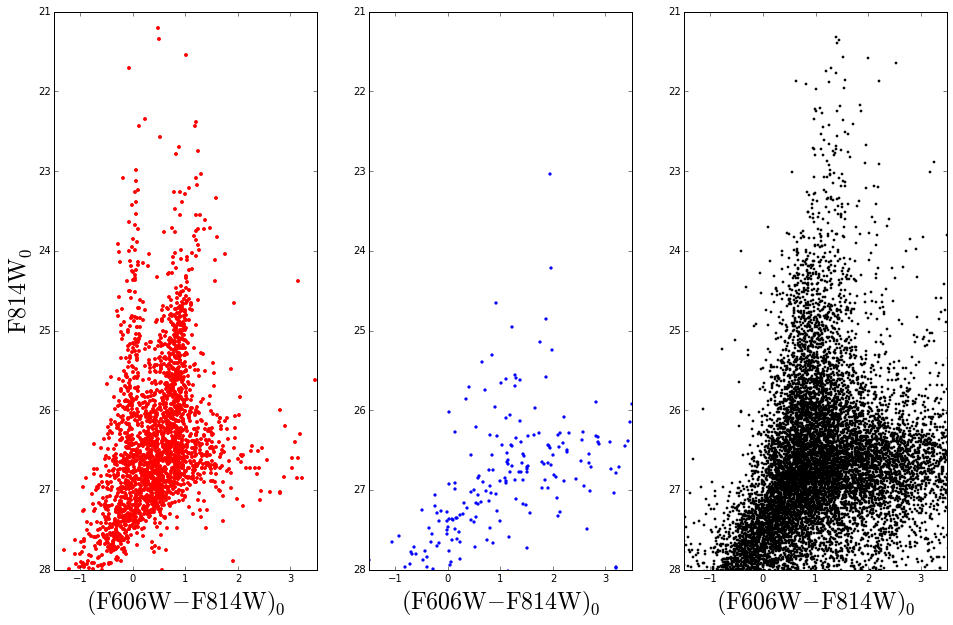

In [100]:
plt.subplot(1,3,1)
plt.scatter(c[msk_dwarf], m[msk_dwarf], s=8, alpha=1, color='r')
xls = plt.xlim(-1.5, 3.5)
yls = plt.ylim(28, 21)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)
plt.ylabel(r'${\rm F814W}_0$',fontsize=24)

plt.subplot(1,3,2)
plt.scatter(c[msk_control], m[msk_control], s=5, alpha=1, color='b')
plt.xlim(*xls)
plt.ylim(*yls)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)

plt.subplot(1,3,3)
plt.scatter(c[other], m[other], s=3, alpha=1, color='k')
plt.xlim(*xls)
plt.ylim(*yls)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)

### now add in S/N rejection

In [115]:
snthresh = 4
sncutoff = (sn>snthresh)&(sn606>snthresh)&(sn814>snthresh)

faintmag = 27

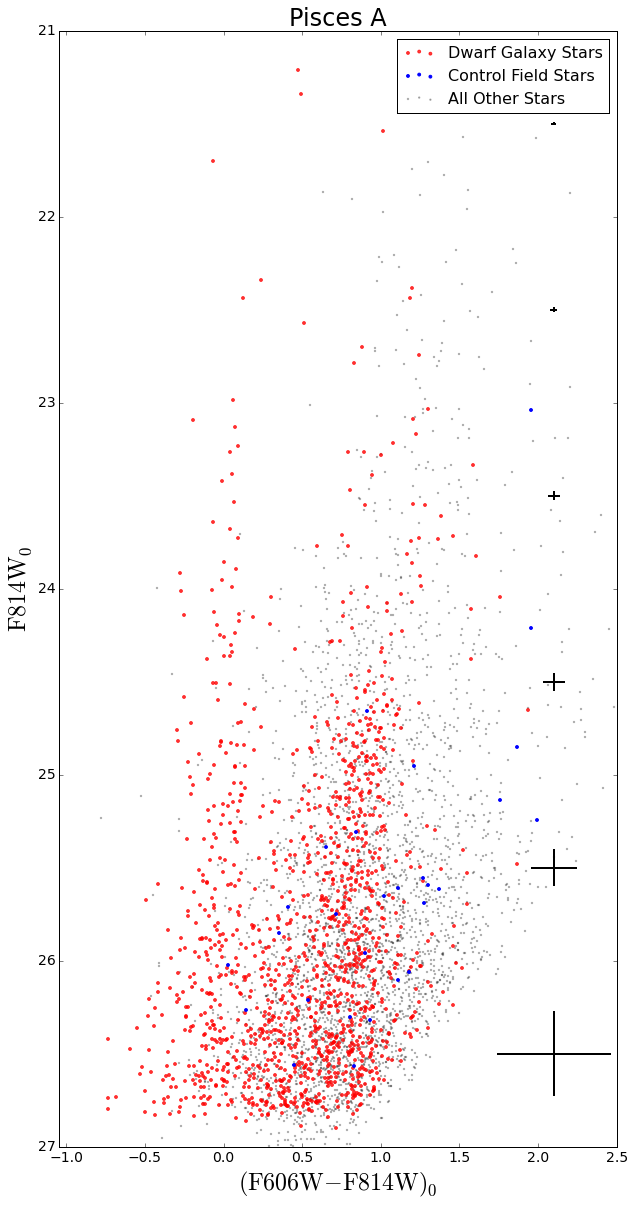

In [116]:
plt.figure(figsize=(10, 20))
plt.clf()

px_ap = 500
msk_dwarf = dpx_dwarf < px_ap
msk_control = dpx_control < px_ap
other = (~msk_dwarf)&(~msk_control)

plt.scatter(c[other&sncutoff], m[other&sncutoff], s=2, alpha=.25, color='k', label='All Other Stars', zorder=1)
plt.scatter(c[msk_control&sncutoff], m[msk_control&sncutoff], s=8, alpha=1, color='b', label='Control Field Stars', zorder=3)
plt.scatter(c[msk_dwarf&sncutoff], m[msk_dwarf&sncutoff], s=8, alpha=.75, color='r', label='Dwarf Galaxy Stars', zorder=2)

plt.xlim(-1.05, 2.5)
plt.ylim(faintmag, 21)

inbox = (min(plt.xlim())<c)&(c<max(plt.xlim()))&(min(plt.ylim())<m)&(m<max(plt.ylim()))
errmagbins = plt.yticks()[0]

binnum = np.digitize(m, errmagbins)
binmags = np.convolve(errmagbins, [0.5,0.5],mode='valid')
ces = [np.median(ce[(bi==binnum)&(ce<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]
mes = [np.median(me[(bi==binnum)&(me<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]

plt.errorbar([2.1]*len(binmags), binmags, mes, ces, fmt=None, capsize=0,ecolor='k',elinewidth=2)

plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)
plt.xticks(fontsize=14)
plt.ylabel(r'${\rm F814W}_0$',fontsize=24)
plt.yticks(fontsize=14)
plt.title('Pisces A',fontsize=24)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=16)
save_pub_figure('PiscA_cmd')

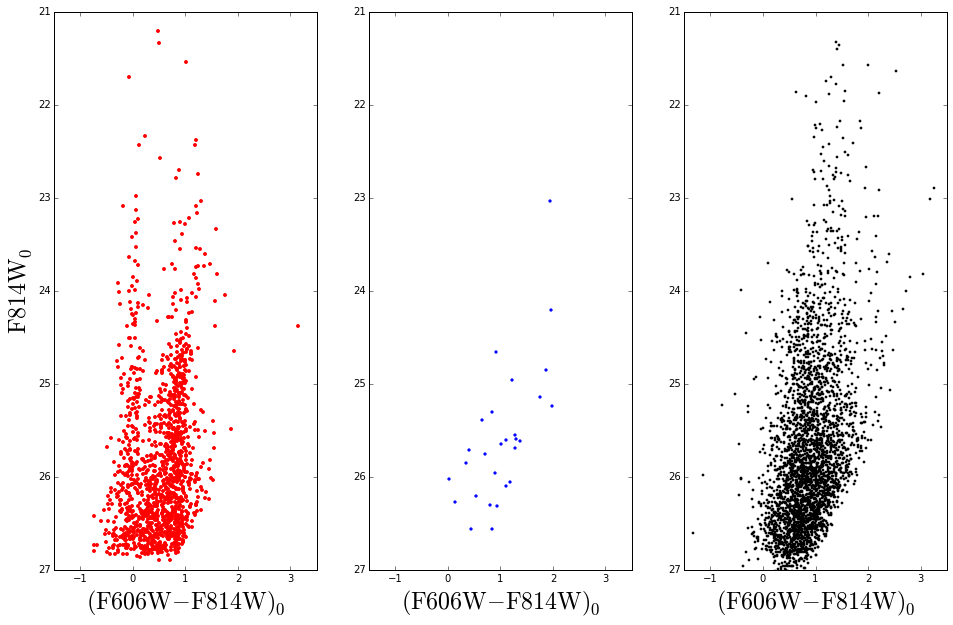

In [104]:
plt.subplot(1,3,1)
plt.scatter(c[msk_dwarf&sncutoff], m[msk_dwarf&sncutoff], s=8, alpha=1, color='r')
xls = plt.xlim(-1.5, 3.5)
yls = plt.ylim(faintmag, 21)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)
plt.ylabel(r'${\rm F814W}_0$',fontsize=24)

plt.subplot(1,3,2)
plt.scatter(c[msk_control&sncutoff], m[msk_control&sncutoff], s=5, alpha=1, color='b')
plt.xlim(*xls)
plt.ylim(*yls)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)

plt.subplot(1,3,3)
plt.scatter(c[other&sncutoff], m[other&sncutoff], s=3, alpha=1, color='k')
plt.xlim(*xls)
plt.ylim(*yls)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)

## Artificial Stars

In [401]:
dfake = np.loadtxt('PiscA_dolphot/piscA.fake')

In [402]:
dpx_dwarf_fake = np.hypot(x0-dfake[:,2],y0-dfake[:,3])
dpx_control_fake = np.hypot(xc-dfake[:,2],yc-dfake[:,3])

In [403]:
(np.sum(dpx_dwarf_fake < px_ap), np.sum(dpx_control_fake < px_ap)), (np.sum(dpx_dwarf < px_ap), np.sum(dpx_control < px_ap))

((789, 766), (2541, 374))

In [404]:
m606_fake0, m814_fake0 = dfake[:, 5], dfake[:,13]

m606_fake = dfake[:,15+20]
m606e_fake = dfake[:,17+20]
m814_fake = dfake[:,28+20]
m814e_fake = dfake[:,30+20]

In [405]:
def make_fake_plot(m_fake0, m_fake, me_fake, ddwarf, filtername, 
                   binedges=(23,28), nbins=21, px_ap=px_ap):
    msk = ddwarf < px_ap

    x = m_fake0
    y = m_fake0 - m_fake
    ye = me_fake


    ebin_edges = np.linspace(binedges[0], binedges[1], nbins)
    ebincens = []
    errinbin = []
    stdinbin = []
    for l, u in zip(ebin_edges[:-1], ebin_edges[1:]):
        ebincens.append((l + u)/2)
        binmsk = (l<x)&(x<u)&(np.abs(y)<5)
        errinbin.append(np.mean(ye[binmsk]))
        stdinbin.append(np.std(y[binmsk]))


    plt.scatter(x[~msk], y[~msk],c='k',edgecolor='none',s=3, label='others')
    plt.scatter(x[msk], y[msk],c='r',edgecolor='none',s=10, label='close to dwarf')
    plt.errorbar(ebincens, [0]*len(ebincens), errinbin, fmt=None, capsize=0,ecolor='c',elinewidth=3)

    plt.ylim(-3,3)
    plt.xlim(23-.05,28.05)
    plt.xlabel(filtername + ' (input)')
    plt.ylabel('{0}_in - {0}_out'.format(filtername))

    np.array(stdinbin), np.array(errinbin), 

    plt.scatter(ebincens,2*np.array(errinbin)/np.array(stdinbin),color='b',edgecolor='none',
                s=40, label='2 mean err/std of delta')
    plt.axhline(1,c='k',ls='--')
    plt.legend(loc=0)

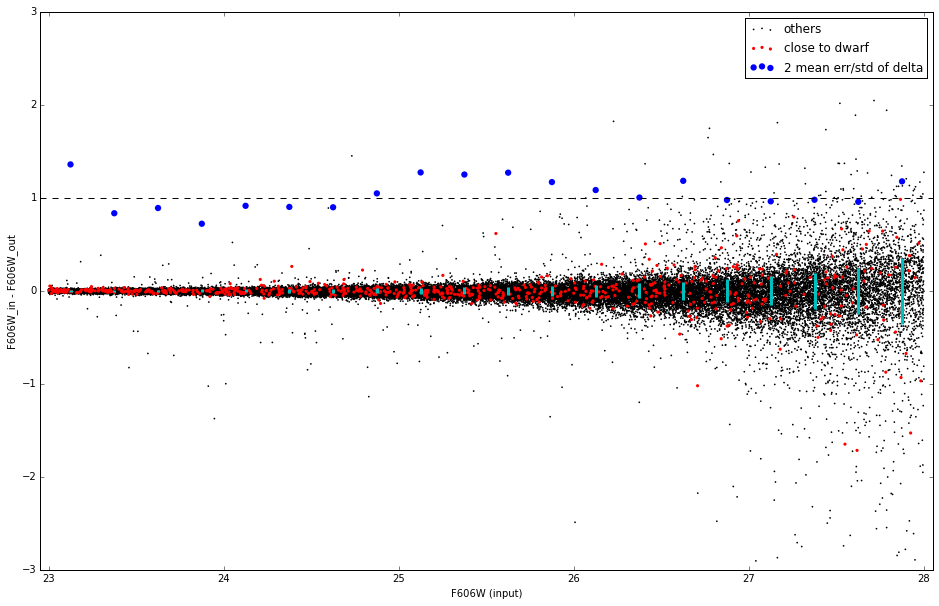

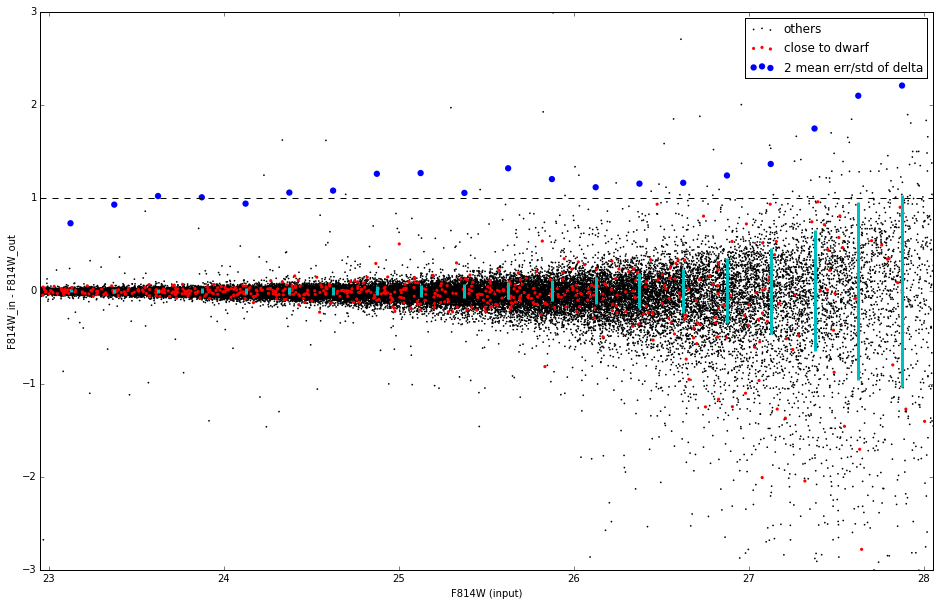

In [406]:
plt.figure()
make_fake_plot(m606_fake0, m606_fake, m606e_fake, dpx_dwarf_fake, 'F606W')
plt.figure()
make_fake_plot(m814_fake0, m814_fake, m814e_fake, dpx_dwarf_fake, 'F814W')

## Now characterizing the AST results

(21, 29)

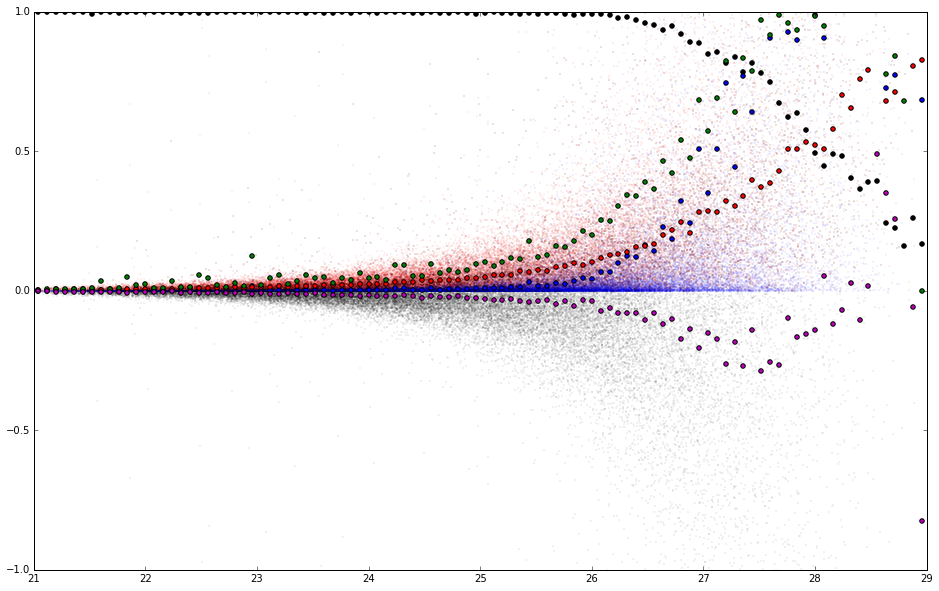

In [407]:
#average err in bins
m = m814_fake0
e = m814_fake0 - m814_fake

m1, m2 = 21, 29

bin_edges = np.linspace(m1, m2, 101)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

ninbin = np.histogram(m, bins=bin_edges)[0]
bin_number = np.digitize(m, bins=bin_edges, right=True)

det_frac = []
moffset = []
meansqerr = []
meanabserr = []
medsqerr = []
medabserr = []
stds = []
for bn in np.unique(bin_number):
    msk = bin_number==bn
    mbin = m[msk]
    ebin = e[msk]
    real = ebin>-40
    
    det_frac.append(np.sum(real)/np.sum(msk))
    moffset.append(np.mean(ebin[real]))
    
    meansqerr.append(np.mean(ebin[real]**2))
    meanabserr.append(np.mean(np.abs(ebin[real])))
    
    medsqerr.append(np.median(ebin[real]**2))
    medabserr.append(np.median(np.abs(ebin[real])))
    
    stds.append(np.std(ebin[real]))
    
    
plt.scatter(m, np.abs(e), alpha=.1, s=3, lw=0, c='r')
plt.scatter(m, e**2, alpha=.1, s=3, lw=0, c='b')
plt.scatter(m, e, alpha=.1, s=3, lw=0, c='k')

plt.scatter(bin_centers, det_frac, c='k')

plt.scatter(bin_centers, meansqerr, c='b')
plt.scatter(bin_centers, medabserr, c='r')
plt.scatter(bin_centers, stds, c='g')

plt.scatter(bin_centers, moffset, c='m')


plt.ylim(-1,1)
plt.xlim(m1, m2)


## Find functions to fit the unc/completeness funcs 

(<Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)>,
 <Legendre1D(20, c0=57676161.84323706, c1=-17209959.789020445, c2=1385496.6301227284, c3=-48414.04021363003, c4=575.3901341533629, c5=10.075725399188295, c6=-0.3447705463476991, c7=0.0007792119869912815, c8=7.72522004106441e-05, c9=-6.701508329887627e-07, c10=-3.974882493931565e-09, c11=-2.029820821762394e-10, c12=7.68681849196244e-13, c13=3.3497546540936376e-13, c14=-6.383793879457606e-15, c15=-3.727412016916026e-17, c16=1.1501905314

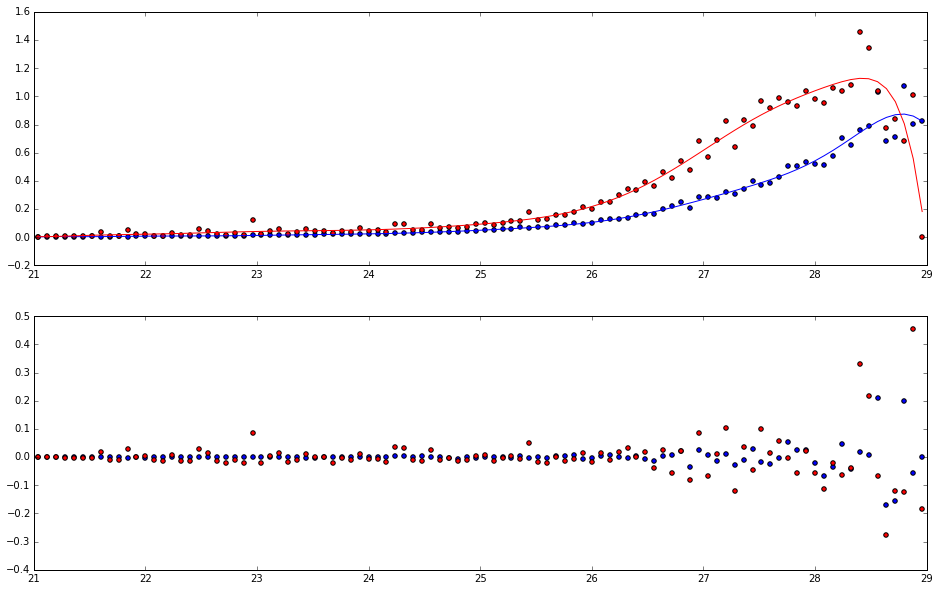

In [408]:
mod0 = models.Legendre1D(20, window=[m1, m2])
fr = fitting.LevMarLSQFitter()

x = bin_centers
y = medabserr
y2 = stds


mod1 = fr(mod0, x, y)
mod2 = fr(mod0, x, y2)

plt.subplot(2,1,1)

plt.plot(x, mod1(x))
plt.plot(x, mod2(x), c='r')

plt.scatter(x,y)
plt.scatter(x,y2, c='r')
plt.xlim(m1, m2)

plt.subplot(2,1,2)
plt.scatter(x, y-mod1(x))
plt.scatter(x, y2-mod2(x), c='r')
plt.xlim(m1, m2)

mod1, mod2

### Bias

(-0.3, 0)

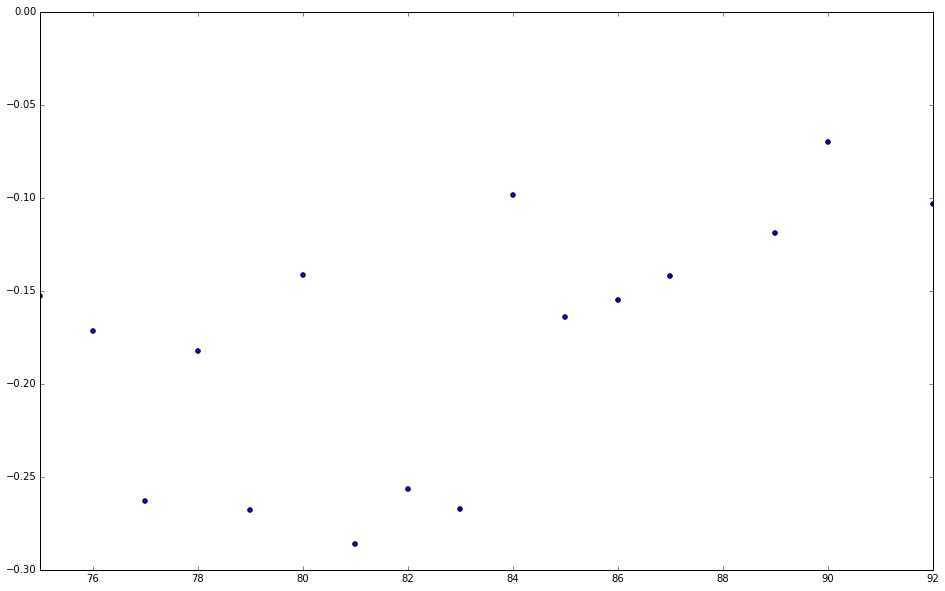

In [417]:
plt.scatter(np.arange(len(y)), y)
plt.xlim(75,92)
plt.ylim(-.3,0)

(array([ 21.04,  21.04,  21.04,  21.04,  25.04,  27.04,  28.  ,  28.24,
         28.48,  28.64,  28.72,  28.96,  28.96,  28.96,  28.96]),
 array([  2.27431926e-04,  -1.32821783e-02,   2.46137242e-03,
         -6.86495474e-02,  -3.29464037e-01,   2.55491886e-03,
          1.95396586e-02,   3.14164071e-01,   4.38917629e-01,
          1.50361261e+00,   5.16925592e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 3)

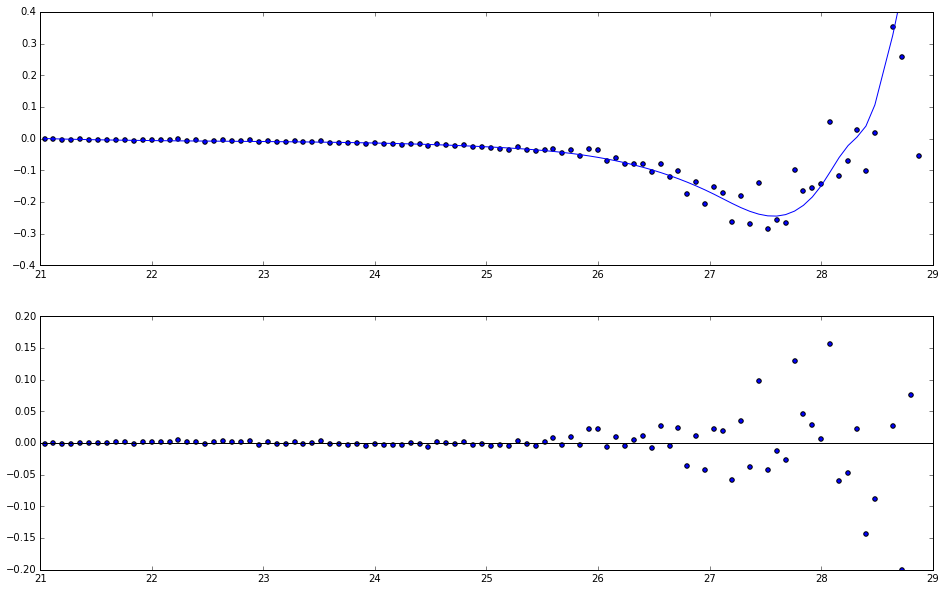

In [420]:
#spline
x = bin_centers
y = np.array(moffset)

ws = np.ones_like(x)
ws[-2:] = 0
ws[80] = ws[84] = 0

spl = interpolate.UnivariateSpline(x, y, s=0.2, w=ws)

plt.subplot(2,1,1)

plt.plot(x, spl(x))
plt.scatter(x,y)
plt.xlim(m1, m2)
plt.ylim(-.4,.4)

plt.subplot(2,1,2)
plt.axhline(0, color='k')
plt.scatter(x, y-spl(x))
plt.xlim(m1, m2)
plt.ylim(-.2,.2)

spl._eval_args

### Completeness 

<Logistic1D(x0=28.114638487444847, w=-0.5461931154575592)>

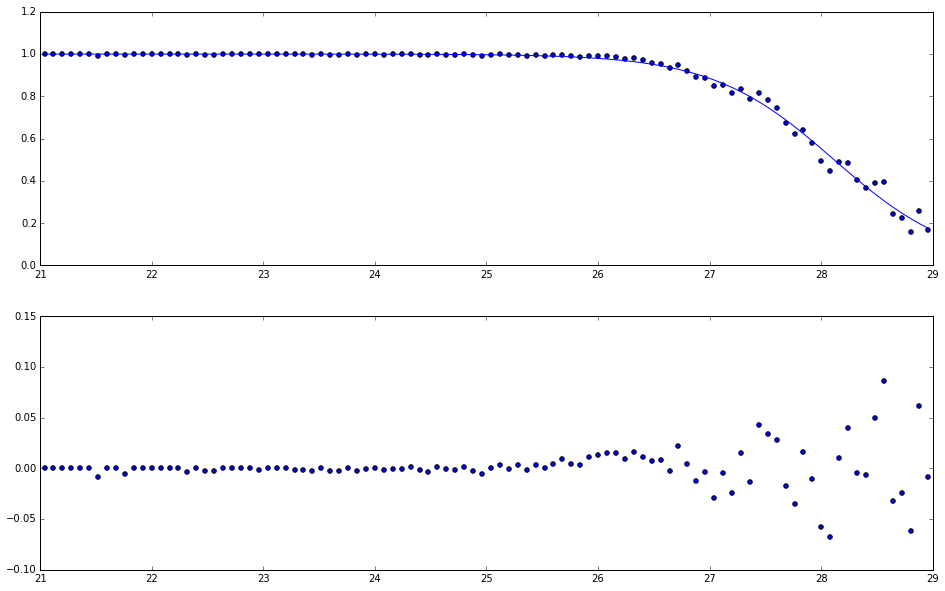

In [223]:
mod0 = Logistic1D(x0=28, w=-1)
fr = fitting.LevMarLSQFitter()

x = bin_centers
y = det_frac

mod_det = fr(mod0, x, y)

plt.subplot(2,1,1)

plt.plot(x, mod_det(x))

plt.scatter(x,y)
plt.xlim(m1, m2)

plt.subplot(2,1,2)
plt.scatter(x, y-mod_det(x))
plt.xlim(m1, m2)

mod_det

# Pisc B

In [117]:
d = np.loadtxt('PiscB_dolphot/piscB')
wcs = WCS(fits.getheader('PiscB_dolphot/PiscB_F606W_drc.chip1.fits'))

#object is roughly here
x0 = 4250
y0 = 5900

#control area
xc = 3500
yc = 3000

sc0 = SkyCoord.from_pixel(x0, y0, wcs)

In [118]:
ebvmap = IrsaDust.get_images(sc0,2*u.degree, 'ebv')[0][0].data
ebv = ebvmap[ebvmap.shape[0]//2, ebvmap.shape[0]//2]
A606W = ebv*2.471 # from S & F 11
A814W = ebv*1.526 # from S & F 11
A606W, A814W

(0.14023352869099867, 0.086603142364412772)

In [119]:
# only use good stars
ds = d[d[:, 10]<2]

m606 = ds[:,15] - A606W
m606e = ds[:,17]
m814 = ds[:,28] - A814W
m814e = ds[:,30]

dpx_dwarf = np.hypot(x0-ds[:,2],y0-ds[:,3])
dpx_control = np.hypot(xc-ds[:,2],yc-ds[:,3])

In [120]:
sn = ds[:, 5]
sn606 = ds[:, 19]
sn814 = ds[:, 32]

In [121]:
 ce = np.hypot(m606e, m814e)
 me = m814e
 c = m606-m814
 m = m814

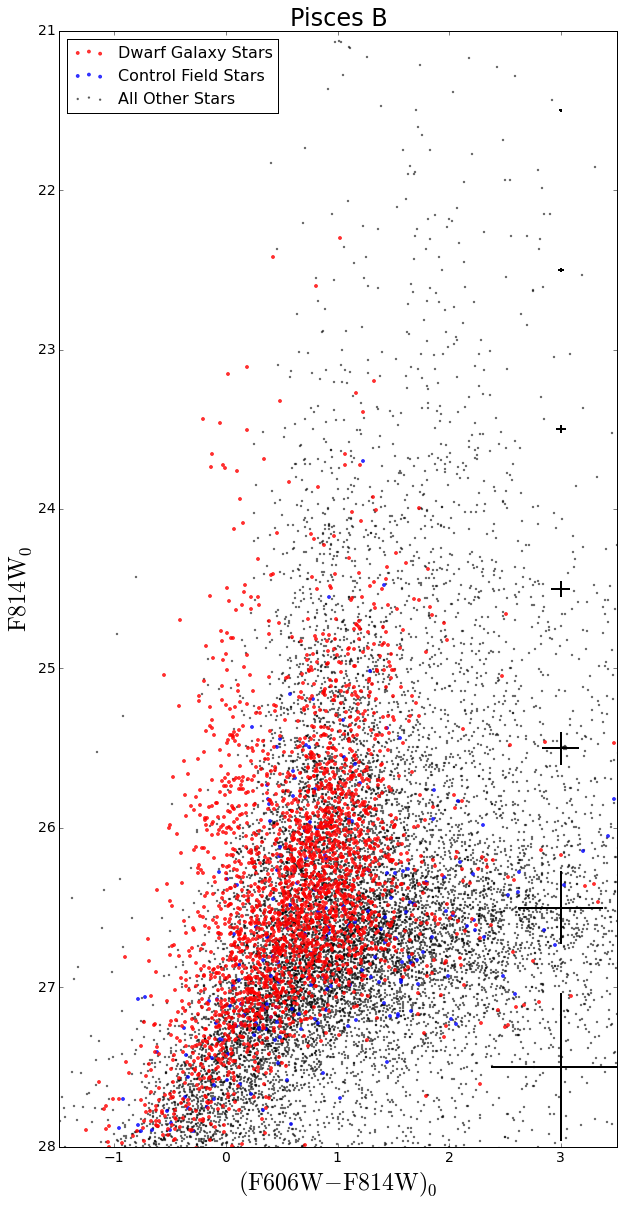

In [64]:
plt.figure(figsize=(10, 20))
plt.clf()

px_ap = 500
msk_dwarf = dpx_dwarf < px_ap
msk_control = dpx_control < px_ap
other = (~msk_dwarf)&(~msk_control)

plt.scatter(c[other], m[other], s=2, alpha=.5, color='k', label='All Other Stars')
plt.scatter(c[msk_control], m[msk_control], s=8, alpha=.75, color='b', label='Control Field Stars')
plt.scatter(c[msk_dwarf], m[msk_dwarf], s=8, alpha=.75, color='r', label='Dwarf Galaxy Stars')
plt.xlim(-1.5, 3.5)
plt.ylim(28, 21)

inbox = (min(plt.xlim())<c)&(c<max(plt.xlim()))&(min(plt.ylim())<m)&(m<max(plt.ylim()))
errmagbins = plt.yticks()[0]

binnum = np.digitize(m, errmagbins)
binmags = np.convolve(errmagbins, [0.5,0.5],mode='valid')
ces = [np.median(ce[(bi==binnum)&(ce<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]
mes = [np.median(me[(bi==binnum)&(me<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]

plt.errorbar([3]*len(binmags), binmags, mes, ces, fmt=None, capsize=0,ecolor='k',elinewidth=2)

plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)
plt.xticks(fontsize=14)
plt.ylabel(r'${\rm F814W}_0$',fontsize=24)
plt.yticks(fontsize=14)
plt.title('Pisces B',fontsize=24)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=16)
#save_pub_figure('PiscB_cmd')

(28, 21)

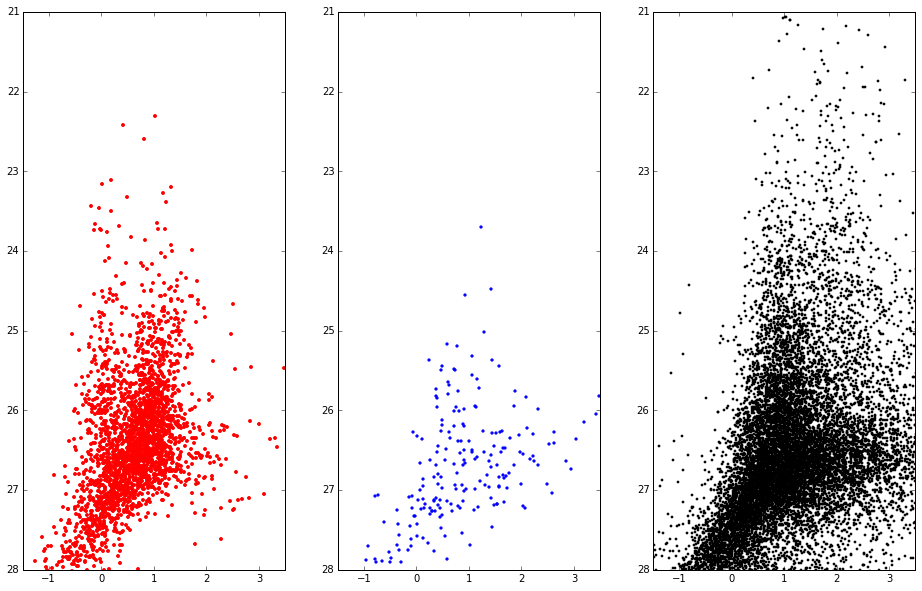

In [65]:
plt.subplot(1,3,1)
plt.scatter(c[msk_dwarf], m[msk_dwarf], s=8, alpha=1, color='r')
xls = plt.xlim(-1.5, 3.5)
yls = plt.ylim(28, 21)

plt.subplot(1,3,2)
plt.scatter(c[msk_control], m[msk_control], s=5, alpha=1, color='b')
plt.xlim(*xls)
plt.ylim(*yls)

plt.subplot(1,3,3)
plt.scatter(c[other], m[other], s=3, alpha=1, color='k')
plt.xlim(*xls)
plt.ylim(*yls)

### Now add in S/N rejection

In [122]:
snthresh = 4.
sncutoff = (sn>snthresh)&(sn606>snthresh)&(sn814>snthresh)

faintmag = 27

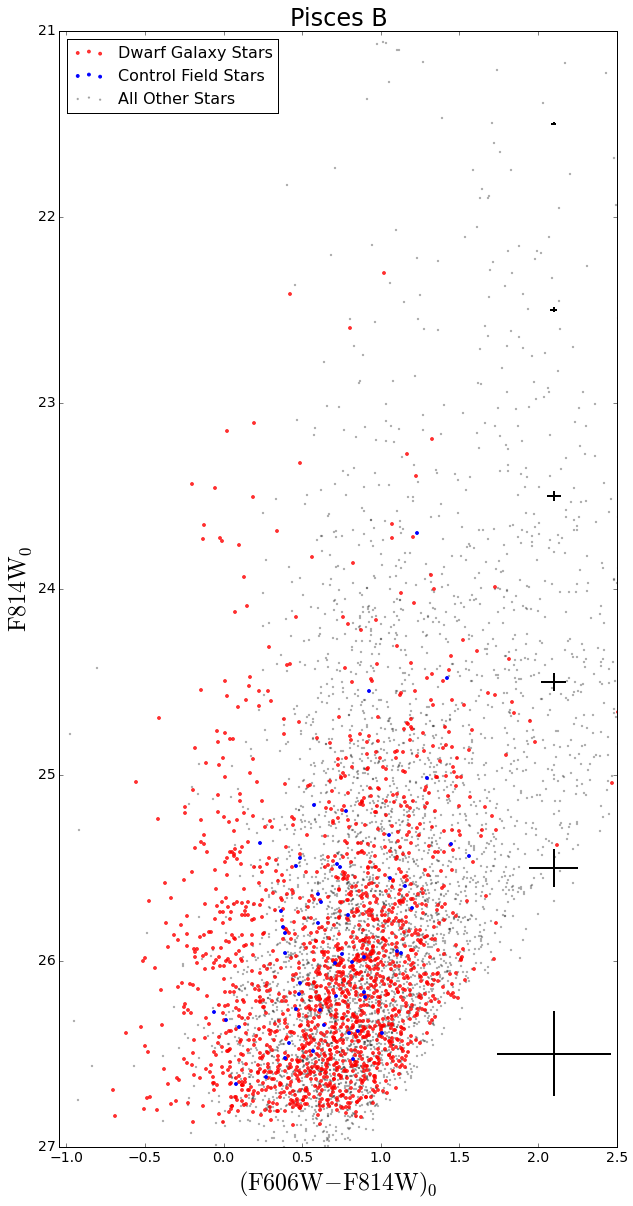

In [123]:
plt.figure(figsize=(10, 20))
plt.clf()

px_ap = 500
msk_dwarf = dpx_dwarf < px_ap
msk_control = dpx_control < px_ap
other = (~msk_dwarf)&(~msk_control)

plt.scatter(c[other&sncutoff], m[other&sncutoff], s=2, alpha=.25, color='k', label='All Other Stars', zorder=1)
plt.scatter(c[msk_control&sncutoff], m[msk_control&sncutoff], s=8, alpha=1, color='b', label='Control Field Stars', zorder=3)
plt.scatter(c[msk_dwarf&sncutoff], m[msk_dwarf&sncutoff], s=8, alpha=.75, color='r', label='Dwarf Galaxy Stars', zorder=2)
plt.xlim(-1.05, 2.5)
plt.ylim(faintmag, 21)

inbox = (min(plt.xlim())<c)&(c<max(plt.xlim()))&(min(plt.ylim())<m)&(m<max(plt.ylim()))
errmagbins = plt.yticks()[0]

binnum = np.digitize(m, errmagbins)
binmags = np.convolve(errmagbins, [0.5,0.5],mode='valid')
ces = [np.median(ce[(bi==binnum)&(ce<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]
mes = [np.median(me[(bi==binnum)&(me<9)&inbox]) for bi in np.arange(len(errmagbins))[1:]]

plt.errorbar([2.1]*len(binmags), binmags, mes, ces, fmt=None, capsize=0,ecolor='k',elinewidth=2)

plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)
plt.xticks(fontsize=14)
plt.ylabel(r'${\rm F814W}_0$',fontsize=24)
plt.yticks(fontsize=14)
plt.title('Pisces B',fontsize=24)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=16)
save_pub_figure('PiscB_cmd')

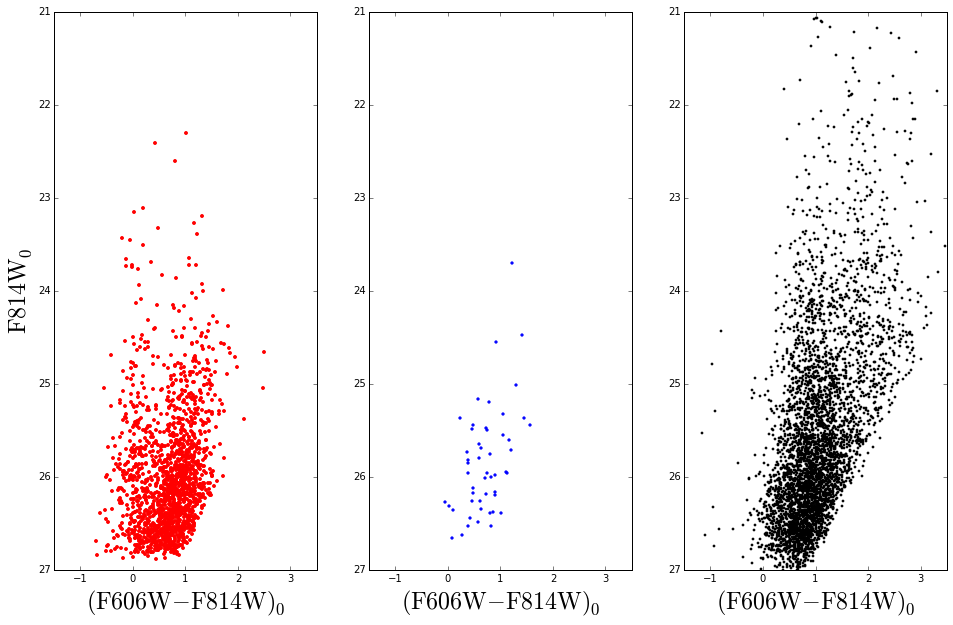

In [85]:
plt.subplot(1,3,1)
plt.scatter(c[msk_dwarf&sncutoff], m[msk_dwarf&sncutoff], s=8, alpha=1, color='r')
xls = plt.xlim(-1.5, 3.5)
yls = plt.ylim(faintmag, 21)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)
plt.ylabel(r'${\rm F814W}_0$',fontsize=24)

plt.subplot(1,3,2)
plt.scatter(c[msk_control&sncutoff], m[msk_control&sncutoff], s=5, alpha=1, color='b')
plt.xlim(*xls)
plt.ylim(*yls)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)

plt.subplot(1,3,3)
plt.scatter(c[other&sncutoff], m[other&sncutoff], s=3, alpha=1, color='k')
plt.xlim(*xls)
plt.ylim(*yls)
plt.xlabel(r'$({\rm F606W - F814W})_0$',fontsize=24)

## Artificial stars

In [87]:
dfake = np.loadtxt('PiscB_dolphot/piscB.fake')

In [88]:
dpx_dwarf_fake = np.hypot(x0-dfake[:,2],y0-dfake[:,3])
dpx_control_fake = np.hypot(xc-dfake[:,2],yc-dfake[:,3])

In [89]:
(np.sum(dpx_dwarf_fake < px_ap), np.sum(dpx_control_fake < px_ap)), (np.sum(dpx_dwarf < px_ap), np.sum(dpx_control < px_ap))

((764, 799), (2781, 355))

In [90]:
m606_fake0, m814_fake0 = dfake[:, 5], dfake[:,13]

m606_fake = dfake[:,15+20]
m606e_fake = dfake[:,17+20]
m814_fake = dfake[:,28+20]
m814e_fake = dfake[:,30+20]

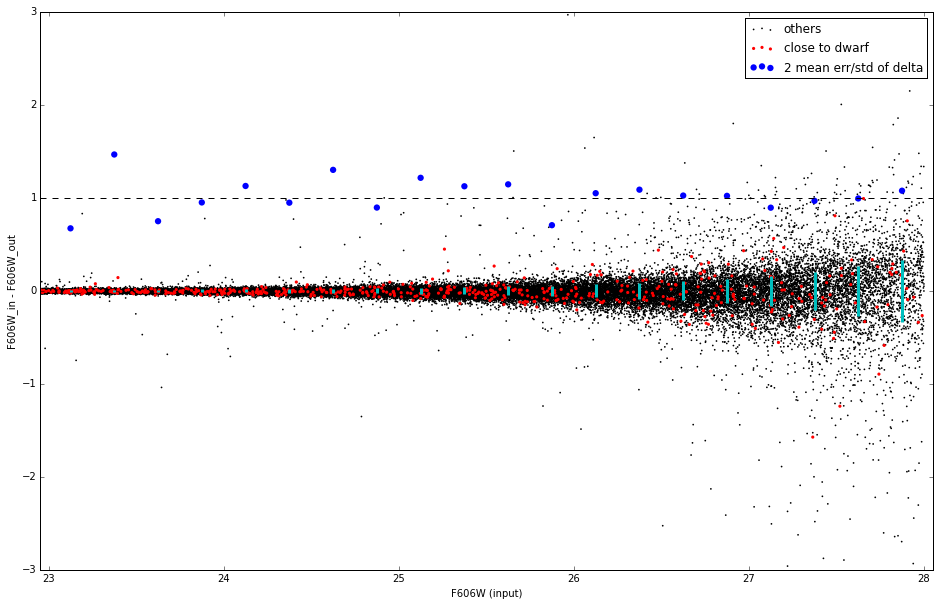

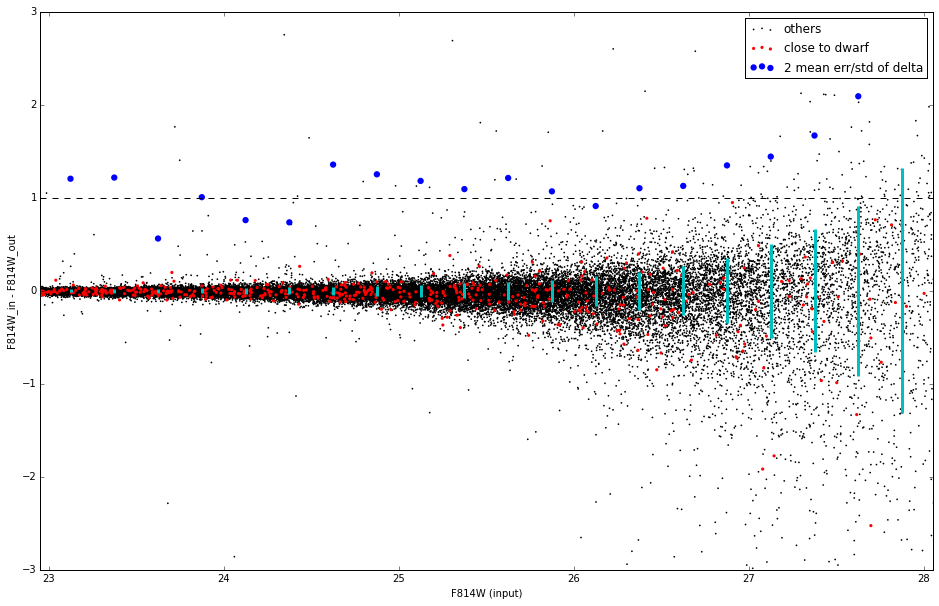

In [91]:
plt.figure()
make_fake_plot(m606_fake0, m606_fake, m606e_fake, dpx_dwarf_fake, 'F606W')
plt.figure()
make_fake_plot(m814_fake0, m814_fake, m814e_fake, dpx_dwarf_fake, 'F814W')

## Now characterizing the AST results

(21, 29)

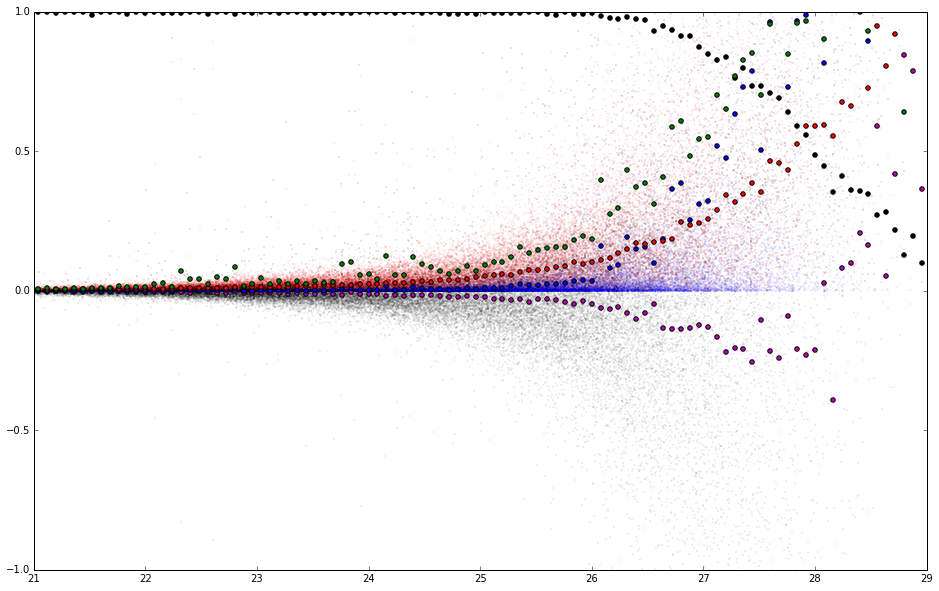

In [95]:
#average err in bins
m = m814_fake0
e = m814_fake0 - m814_fake

m1, m2 = 21, 29

bin_edges = np.linspace(m1, m2, 101)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

ninbin = np.histogram(m, bins=bin_edges)[0]
bin_number = np.digitize(m, bins=bin_edges, right=True)

det_frac = []
moffset = []
meansqerr = []
meanabserr = []
medsqerr = []
medabserr = []
stds = []
for bn in np.unique(bin_number):
    if bn==100:
        continue
    msk = bin_number==bn
    mbin = m[msk]
    ebin = e[msk]
    real = ebin>-40
    
    det_frac.append(np.sum(real)/np.sum(msk))
    
    moffset.append(np.mean(ebin[real]))
    
    meansqerr.append(np.mean(ebin[real]**2))
    meanabserr.append(np.mean(np.abs(ebin[real])))
    
    medsqerr.append(np.median(ebin[real]**2))
    medabserr.append(np.median(np.abs(ebin[real])))
    
    stds.append(np.std(ebin[real]))
    
    
plt.scatter(m, np.abs(e), alpha=.1, s=3, lw=0, c='r')
plt.scatter(m, e**2, alpha=.1, s=3, lw=0, c='b')
plt.scatter(m, e, alpha=.1, s=3, lw=0, c='k')

plt.scatter(bin_centers, det_frac, c='k')
plt.scatter(bin_centers, moffset, c='m')

plt.scatter(bin_centers, meansqerr, c='b')
plt.scatter(bin_centers, medabserr, c='r')
plt.scatter(bin_centers, stds, c='g')


plt.ylim(-1,1)
plt.xlim(m1, m2)


## Find functions to fit the unc/completeness funcs 

(<Legendre1D(20, c0=394461317.10979784, c1=-145597820.62642878, c2=14956699.130353978, c3=-713036.8987249642, c4=15795.783970188611, c5=-66.67548994107459, c6=-2.5718562940123766, c7=-0.012567092851103162, c8=0.0010443650954728937, c9=1.4248780811847509e-05, c10=-2.9769679739652196e-07, c11=-1.0002176285392608e-08, c12=2.920121507961471e-11, c13=7.478998206297859e-12, c14=-8.29591303050837e-14, c15=-1.1449564824511707e-15, c16=7.328311870318666e-18, c17=6.402700451974091e-19, c18=-1.276065361237432e-20, c19=9.642762541452898e-23, c20=-2.718091289820745e-25)>,
 <Legendre1D(20, c0=-39777086251.09737, c1=13451855931.733442, c2=-1223621864.2439382, c3=47076269.76595876, c4=-498478.26427469973, c5=-18791.41582885179, c6=536.3837173941207, c7=0.4517408324798168, c8=-0.10293790054132315, c9=-0.0009715513576203023, c10=1.0159277523101033e-05, c11=8.302995574933766e-07, c12=8.949417215921738e-09, c13=-7.258927069443237e-10, c14=3.4644477870943368e-12, c15=1.5511693283997184e-13, c16=-3.58583737

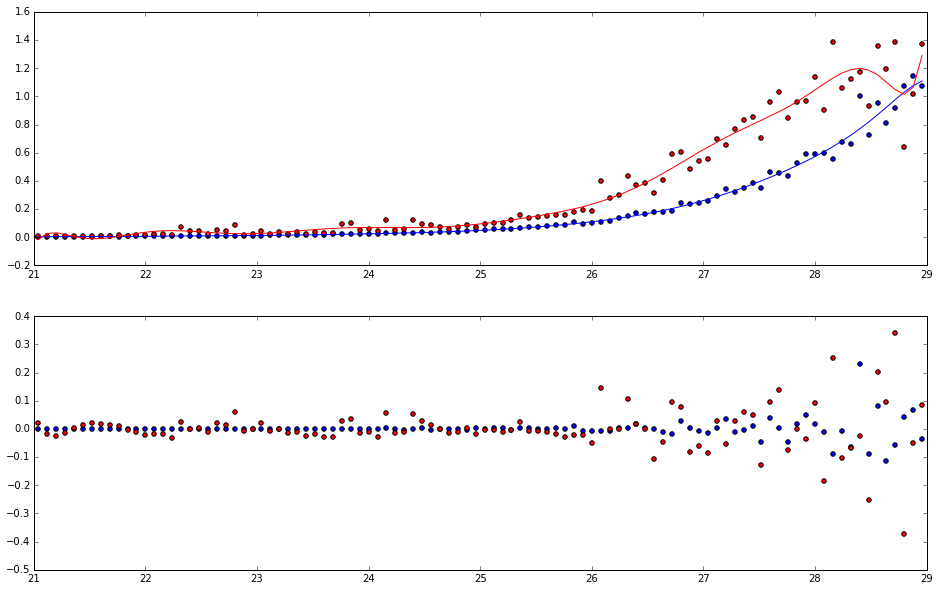

In [246]:
mod0 = models.Legendre1D(20, window=[m1, m2])
fr = fitting.LevMarLSQFitter()

x = bin_centers
y = medabserr
y2 = stds


mod1 = fr(mod0, x, y)
mod2 = fr(mod0, x, y2)

plt.subplot(2,1,1)

plt.plot(x, mod1(x))
plt.plot(x, mod2(x), c='r')

plt.scatter(x,y)
plt.scatter(x,y2, c='r')
plt.xlim(m1, m2)

plt.subplot(2,1,2)
plt.scatter(x, y-mod1(x))
plt.scatter(x, y2-mod2(x), c='r')
plt.xlim(m1, m2)

mod1, mod2

### Bias 

(array([ 21.04,  21.04,  21.04,  21.04,  25.04,  27.04,  28.  ,  28.48,
         28.72,  28.96,  28.96,  28.96,  28.96]),
 array([ -3.54954266e-03,   3.79688149e-04,  -1.47134921e-02,
         -4.52460816e-02,  -3.48736930e-01,   7.44898654e-02,
          5.90351487e-01,   6.74639098e-01,   5.15202077e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 3)

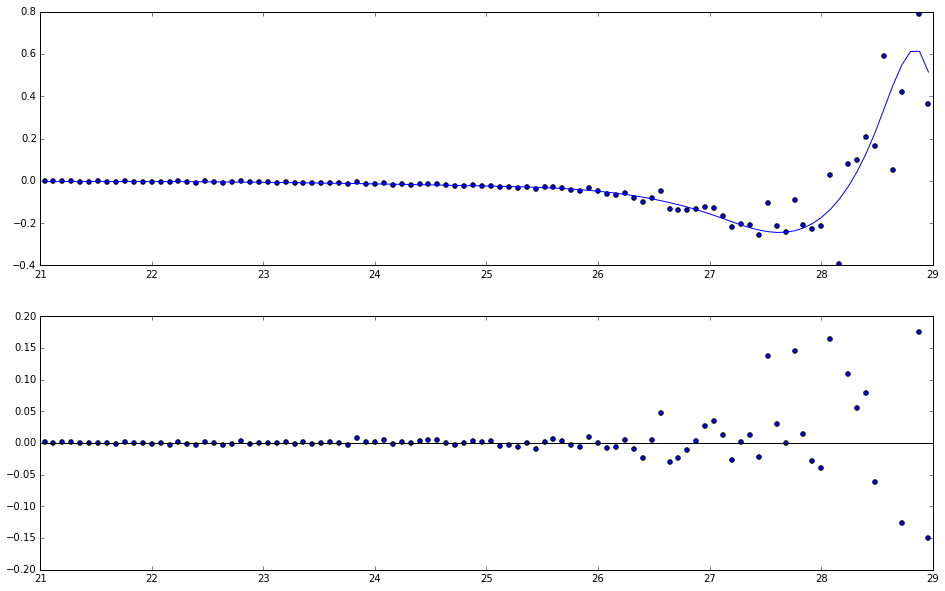

In [390]:
#spline
x = bin_centers
y = np.array(moffset)

ws = np.ones_like(x)
ws[81] = ws[84] = 0

spl = interpolate.UnivariateSpline(x, y, s=0.5, w=ws)

plt.subplot(2,1,1)

plt.plot(x, spl(x))
plt.scatter(x,y)
plt.xlim(m1, m2)
plt.ylim(-.4,.8)

plt.subplot(2,1,2)
plt.axhline(0, color='k')
plt.scatter(x, y-spl(x))
plt.xlim(m1, m2)
plt.ylim(-.2,.2)

spl._eval_args

### Completeness 

<Logistic1D(x0=28.026095235356163, w=-0.5204023249559749)>

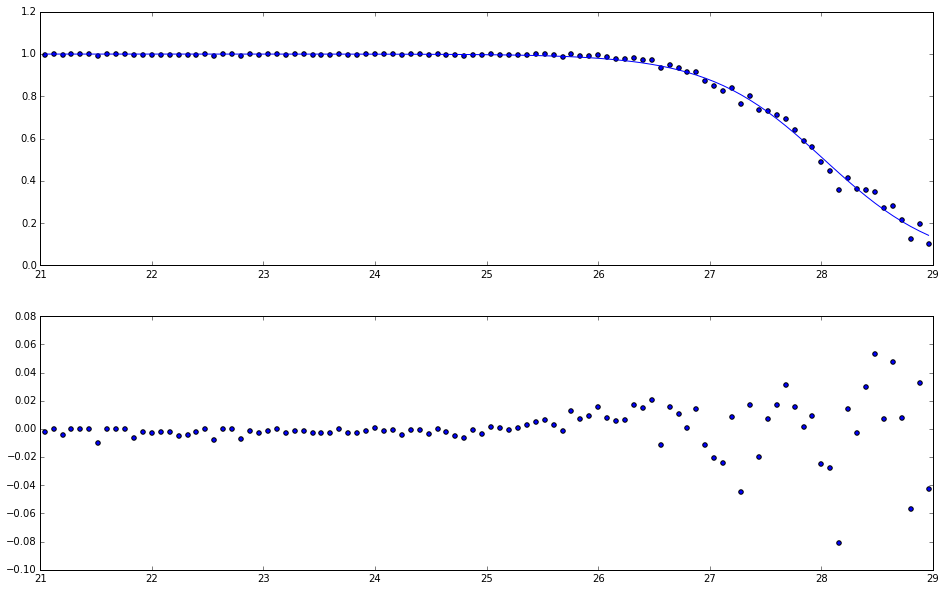

In [247]:
mod0 = Logistic1D(x0=28, w=-1)
fr = fitting.LevMarLSQFitter()

x = bin_centers
y = det_frac

mod_det = fr(mod0, x, y)

plt.subplot(2,1,1)

plt.plot(x, mod_det(x))

plt.scatter(x,y)
plt.xlim(m1, m2)

plt.subplot(2,1,2)
plt.scatter(x, y-mod_det(x))
plt.xlim(m1, m2)

mod_det

# Info

In [28]:
!cat PiscA_dolphot/piscA.columns

1. Extension (zero for base image)
2. Chip (for three-dimensional FITS image)
3. Object X position on reference image (or first image, if no reference)
4. Object Y position on reference image (or first image, if no reference)
5. Chi for fit
6. Signal-to-noise
7. Object sharpness
8. Object roundness
9. Direction of major axis (if not round)
10. Crowding
11. Object type (1=bright star, 2=faint, 3=elongated, 4=hot pixel, 5=extended)
12. Total counts, F606W
13. Total sky level, F606W
14. Normalized count rate, F606W
15. Normalized count rate uncertainty, F606W
16. Instrumental VEGAMAG magnitude, F606W
17. Transformed UBVRI magnitude, F606W
18. Magnitude uncertainty, F606W
19. Chi, F606W
20. Signal-to-noise, F606W
21. Sharpness, F606W
22. Roundness, F606W
23. Crowding, F606W
24. Photometry quality flag, F606W
25. Total counts, F814W
26. Total sky level, F814W
27. Normalized count rate, F814W
28. Normalized count rate uncertainty, F814W
29. Instrumental VEGAMAG magnitude, F814W
30. Transform

##  Example S/N plots

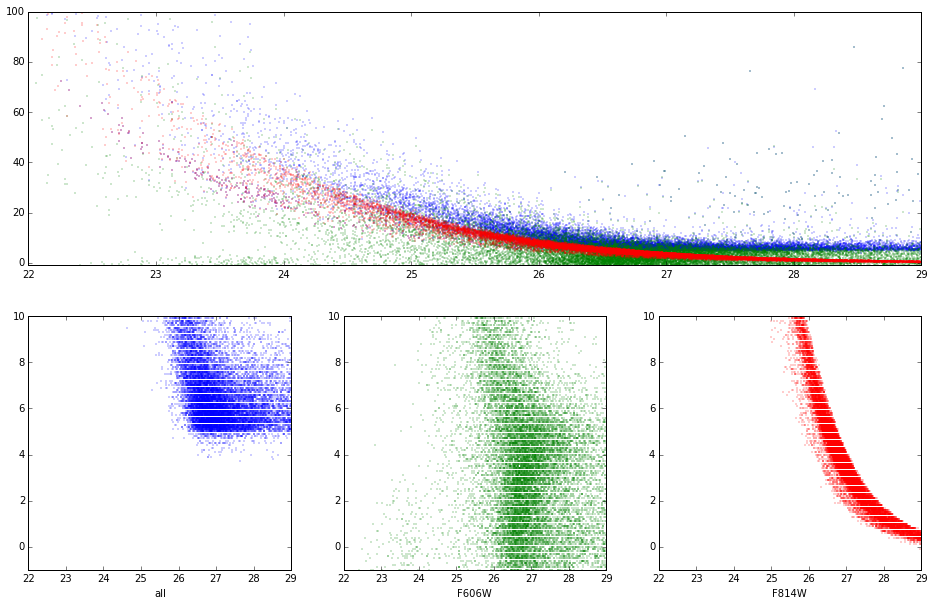

In [79]:
gs = GridSpec(2, 3)

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[1, 2])

for ax in [ax1, ax2]:
    ax.scatter(m, sn, c='b', alpha=.5, lw=0, s=2)
for ax in [ax1, ax3]:
    ax.scatter(m, sn606, c='g', alpha=.5, lw=0, s=2)
for ax in [ax1, ax4]:
    ax.scatter(m, sn814, c='r', alpha=.5, lw=0, s=2)
    
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(22, 29)
    ax.set_ylim(-1, 10)
ax1.set_ylim(-1, 100)

ax2.set_xlabel('all')
ax3.set_xlabel('F606W')
ax4.set_xlabel('F814W')